In [76]:
import import_ipynb
import utils
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [77]:
# préparation des données pour l'entrainement de 1992 - 2020
data_pop = utils.generate_df_from_files("./data_cleaned/population", "_population")
data_fertility = utils.generate_df_from_files("./data_cleaned/fertility", "_fertility")
data_child = utils.generate_df_from_files("./data_cleaned/child_mortality", "_child_mortality")
data_capita = utils.generate_df_from_files("./data_cleaned/gdp_capita", "_gdp_capita")
data_climat = utils.generate_df_from_files("./", "climate_cleaned")[0]


In [78]:
# add columns of data_climat to q_climates



In [79]:

def organize_in_dict(data_list):
    data_dict = {}
    for e in data_list:
        year = int(e.columns[1][:4])
        if year == 2021:
            year = 2020
        data_dict[year] = e.set_index('country')
    return data_dict

data_pop = organize_in_dict(data_pop)
data_fertility = organize_in_dict(data_fertility)
data_child = organize_in_dict(data_child)
data_capita = organize_in_dict(data_capita)
data_climat.set_index('country', inplace=True)

In [80]:
years = [y for y in range(1992, 2021, 4)]

In [81]:
X_list = []
country_names = {}

for annee in years:
    print(annee)
    concatenated_data = pd.concat(
        [ data_pop[annee],
          data_fertility[annee],
          data_child[annee],
          data_capita[annee],
          data_climat ]
        , axis=1, join='inner')

    X_list.append(concatenated_data)
    country_names[annee] = np.array(concatenated_data.index)

X = np.vstack(X_list)
print(X.shape)

1992
1996
2000
2004
2008
2012
2016
2020
(1144, 8)


In [82]:
#preparation des labels pour classification 1992-->2020 labels à 3 classes
import pandas as pd

label_class_3 = pd.read_csv("labels_class_3_class.csv")
label_class_3.set_index('year', inplace=True)

labels_list = []
for year in years:
    print(year)
    label = label_class_3.loc[year]
    labels_list.append(label[country_names[year]])

y_class_3 = np.hstack(labels_list)
y_class_3.shape


1992
1996
2000
2004
2008
2012
2016
2020


(1144,)

In [83]:
# création des label pour tous les événements 1992->2020
import pandas as pd
df_delegations = pd.read_csv("./second_part_countries_cleaned_normalized.csv")
df_delegations.set_index('year', inplace=True)

labels_list = []
for year in years:
    print(year)
    label = df_delegations.loc[year]
    labels_list.append(label[country_names[year]])

y = np.hstack(labels_list)
y.shape

1992
1996
2000
2004
2008
2012
2016
2020


(1144,)

In [84]:
import itertools

In [85]:

country_names_all = list(itertools.chain.from_iterable([country_names[year] for year in years]))

# séparation des données en train et test
X_train, X_test, y_train, y_test, country_train, country_test, cl_train, cl_test = train_test_split(
    X, y, country_names_all, y_class_3,  test_size=0.2, random_state=42)


In [86]:
print(len(cl_train[ cl_train == 0]))
print(len(cl_train[ cl_train == 1]))
print(len(cl_train[ cl_train == 2]))

795
108
12


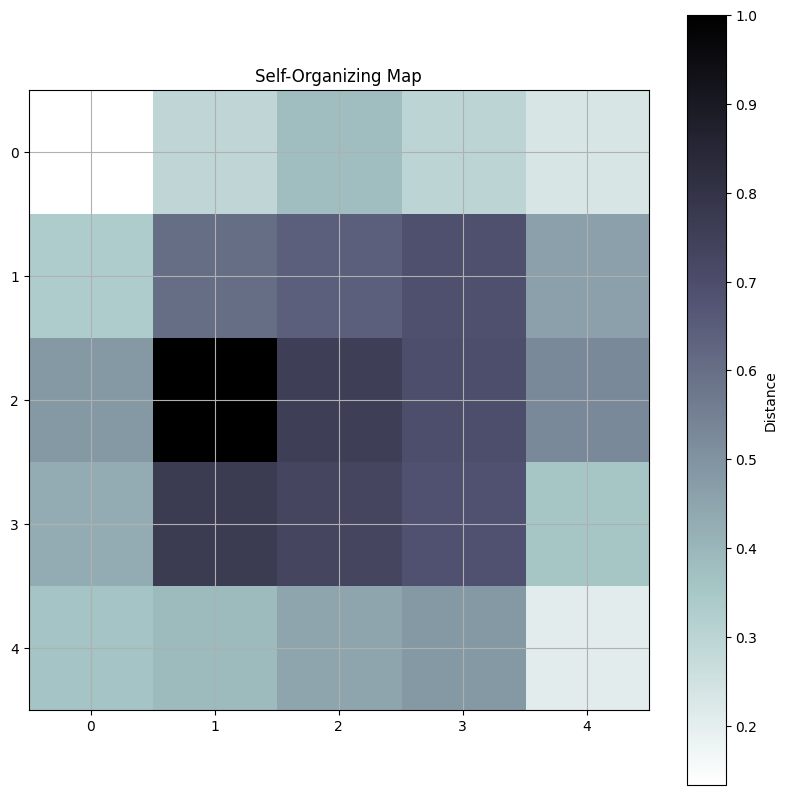


Cluster to Country and Class Mapping:
Cluster (0, 0): 11 countries -> ['Great Britain', 'Luxembourg', 'Belgium', 'USA', 'Slovenia', 'Spain', 'Japan', 'Italy', 'Denmark', 'Netherlands', 'Ireland']
Class distribution in Cluster (0, 0): {0: 1, 1: 1, 2: 1}
Cluster (0, 1): 16 countries -> ['Ukraine', 'Hungary', 'Slovakia', 'Armenia', 'Romania', 'South Korea', 'Latvia', 'Estonia', 'Belarus', 'Turkey', 'Russia', 'Georgia', 'Peru', 'Poland', 'Czech Republic', 'Lithuania']
Class distribution in Cluster (0, 1): {0: 1, 1: 1}
Cluster (0, 2): 10 countries -> ['Hong Kong China', 'Austria', 'Iceland', 'Sweden', 'Switzerland', 'Canada', 'Norway', 'New Zealand', 'Finland', 'Germany']
Class distribution in Cluster (0, 2): {0: 1, 1: 1, 2: 1}
Cluster (0, 3): 6 countries -> ['Chile', 'Iran', 'Kazakhstan', 'Israel', 'Argentina', 'Uzbekistan']
Class distribution in Cluster (0, 3): {0: 1}
Cluster (0, 4): 5 countries -> ['Oman', 'Saudi Arabia', 'UAE', 'Kuwait', 'Qatar']
Class distribution in Cluster (0, 4): {

In [131]:
import numpy as np
from minisom import MiniSom
import matplotlib.pyplot as plt
import pandas as pd

X_som_df = pd.DataFrame(X_train)
X_som_df = X_som_df.drop_duplicates()
X_som = X_som_df.values

country_train_df = pd.DataFrame({'Country': country_train, 'Data': [tuple(row) for row in X_train], 'Class': cl_train})
country_train_df = country_train_df.drop_duplicates(subset='Data', keep='first')
aligned_country_train = country_train_df['Country'].values
aligned_class_train = country_train_df['Class'].values

som_dimensions = (5, 5) 
som = MiniSom(x=som_dimensions[0], y=som_dimensions[1], 
              input_len=X_som.shape[1],
              sigma=1.0, learning_rate=0.5, random_seed=42)

som.random_weights_init(X_som)
som.train_random(data=X_som, num_iteration=1000)

country_to_neuron = {}
for i, x in enumerate(X_som):
    winner = som.winner(x)
    country_to_neuron[aligned_country_train[i]] = winner

clusters = {}
for country, winner in country_to_neuron.items():
    if winner not in clusters:
        clusters[winner] = {'countries': set(), 'classes': set()}
    
    clusters[winner]['countries'].add(country)
    cluster_class = aligned_class_train[np.where(aligned_country_train == country)[0][0]]
    clusters[winner]['classes'].add(cluster_class)

plt.figure(figsize=(10, 10))
plt.title("Self-Organizing Map")
plt.imshow(som.distance_map().T, cmap='bone_r')
plt.colorbar(label='Distance')
plt.grid()
plt.show()

sorted_clusters = sorted(clusters.items(), key=lambda item: (item[0][0], item[0][1]))
print("\nCluster to Country and Class Mapping:")
for cluster, data in sorted_clusters:
    countries = list(data['countries'])
    class_counts = {cls: list(data['classes']).count(cls) for cls in data['classes']}
    
    print(f"Cluster {cluster}: {len(countries)} countries -> {countries[:]}")
    print(f"Class distribution in Cluster {cluster}: {class_counts}")
